In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("hls")
sns.set_context("notebook")

In [338]:
fp = "data/spectral_templates_data_version_july15.h5"

In [ ]:
# To get the chi-squared statistic according to Bardalez et. al.
wavegrids = pd.read_hdf("data/spectral_templates_data_version_june20.h5", key="wavegrid")
range_1 = wavegrids[(wavegrids >= 0.95) & (wavegrids <= 1.35)].dropna().index
range_2 = wavegrids[(wavegrids >= 1.45) & (wavegrids <= 1.80)].dropna().index
range_3 = wavegrids[(wavegrids >= 2.00) & (wavegrids <= 2.35)].dropna().index

In [350]:
def get_binary_single_dfs(_fp):
    _singles_flux = pd.read_hdf(_fp, key="singles_flux")
    _binaries_flux = pd.read_hdf(_fp, key="binaries_flux")

    _singles_noise = pd.read_hdf(_fp, key="singles_noise")
    _binaries_noise = pd.read_hdf(_fp, key="binaries_noise")

    _singles_difference_spectrum = pd.read_hdf(_fp, key="singles_difference_spectrum")
    _binaries_difference_spectrum = pd.read_hdf(_fp, key="binaries_difference_spectrum")

    _singles_flux_dedup = _singles_flux.drop_duplicates(subset="object_name")
    _singles_noise_dedup = _singles_noise.drop_duplicates(subset="object_name")
    _singles_difference_spectrum_dedup = _singles_difference_spectrum.drop_duplicates(
        subset="object_name"
    )

    _singles_merged = _singles_noise_dedup.merge(
        _singles_difference_spectrum_dedup,
        on="object_name",
        suffixes=("_noise", "_diff"),
    )
    _singles_merged = _singles_merged.merge(_singles_flux_dedup, on="object_name")
    _singles_merged = _singles_merged.drop(
        columns=["spectral_type_noise", "spectral_type_diff"]
    )

    _binaries_merged = _binaries_noise.merge(
        _binaries_difference_spectrum, on="object_name", suffixes=("_noise", "_diff")
    )
    _binaries_merged = _binaries_merged.merge(_binaries_flux, on="object_name")

    _binaries_merged = _binaries_merged.drop(columns=["primary_type", "secondary_type"])
    _binaries_merged = _binaries_merged.rename(columns={"system_type": "spectral_type"})
    _binaries_merged = _binaries_merged.drop(columns="object_name")

    return _singles_merged, _binaries_merged


def filter_binaries(
        _binaries_df, primary_min, primary_max, secondary_min, secondary_max
):
    return _binaries_df[
        (_binaries_df["primary_type"] >= primary_min)
        & (_binaries_df["primary_type"] <= primary_max)
        & (_binaries_df["secondary_type"] >= secondary_min)
        & (_binaries_df["secondary_type"] <= secondary_max)
        ]


def filter_singles(_singles_df, min_type, max_type):
    return _singles_df[
        (_singles_df["spectral_type"] >= min_type)
        & (_singles_df["spectral_type"] <= max_type)
        ]


def get_spectral_data(_singles_df, _binaries_df):
    """Get different measurements from merged and deduplicated data."""
    _singles_type = _singles_df["spectral_type"]
    type_map = {"M": 10, "L": 20, "T": 30}

    def condition(x):
        if type(x) == str:
            return int(x[1]) + type_map[x[0]]
        else:
            return x

    _singles_type = _singles_type.apply(condition)

    _singles_flux = _singles_df.loc[
                    :, ~_singles_df.columns.str.contains("noise|diff|type|name")
                    ]
    _singles_noise = _singles_df.loc[:, _singles_df.columns.str.contains("noise")]
    _singles_diff = _singles_df.loc[:, _singles_df.columns.str.contains("diff")]

    # Assuming binaries are already filtered by primary and secondary type groupings
    _binaries_type = _binaries_df["spectral_type"]
    _binaries_flux = _binaries_df.loc[
                     :, ~_binaries_df.columns.str.contains("noise|diff|type|name")
                     ]
    _binaries_noise = _binaries_df.loc[:, _binaries_df.columns.str.contains("noise")]
    _binaries_diff = _binaries_df.loc[:, _binaries_df.columns.str.contains("diff")]

    return (
        _singles_type,
        _singles_flux,
        _singles_noise,
        _singles_diff,
        _binaries_type,
        _binaries_flux,
        _binaries_noise,
        _binaries_diff,
    )


def add_noise(flux_df, noise_df, scale):
    with_noise = np.random.normal(flux_df, noise_df.abs() * scale)
    return with_noise


def compute_snr(flux_df, noise_df, scale):
    return np.nanmedian(
        flux_df.values / ((noise_df.abs() + 1e-50).values * scale), axis=1
    )


def compute_chisq(diff_df, noise_df, scale):
    """Compute chi-squared statistics on same wavelengths as in Bartolez et. al."""
    diff_range_1 = diff_df[["flux_" + str(i) + "_diff" for i in range_1]]
    diff_range_2 = diff_df[["flux_" + str(i) + "_diff" for i in range_2]]
    diff_range_3 = diff_df[["flux_" + str(i) + "_diff" for i in range_3]]

    noise_range_1 = noise_df[["flux_" + str(i) + "_noise" for i in range_1]]
    noise_range_2 = noise_df[["flux_" + str(i) + "_noise" for i in range_2]]
    noise_range_3 = noise_df[["flux_" + str(i) + "_noise" for i in range_3]]

    chisq_df = pd.DataFrame()

    chisq_df["chisq_095_135"] = (
                                        (5 * diff_range_1.values / (noise_range_1.values + 1e-50)) ** 2
                                ).sum(axis=1) / 1e5
    chisq_df["chisq_145_180"] = (
                                        (5 * diff_range_2.values / (noise_range_2.values + 1e-50)) ** 2
                                ).sum(axis=1) / 1e5
    chisq_df["chisq_200_235"] = (
                                        (5 * diff_range_3.values / (noise_range_3.values + 1e-50)) ** 2
                                ).sum(axis=1) / 1e5
    return chisq_df


def feature_engineering(
        _singles_type,
        _singles_flux,
        _singles_noise,
        _binaries_type,
        _binaries_flux,
        _binaries_noise,
        scale,
        _singles_diffs=None,
        _binaries_diffs=None,
        snr=True,
        add_template_diffs=True,
        chisq=True,
        chisq_std=True,
):
    if chisq_std:
        assert chisq

    # Add the noise
    singles_with_noise = add_noise(_singles_flux, _singles_noise, scale)
    binaries_with_noise = add_noise(_binaries_flux, _binaries_noise, scale)

    # Convert from NP array to DataFrame
    singles_with_noise = pd.DataFrame(
        singles_with_noise, columns=_binaries_flux.columns
    )
    binaries_with_noise = pd.DataFrame(
        binaries_with_noise, columns=_binaries_flux.columns
    )

    # Compute signal-to-noise ratio (NOT TO USE AS A FEATURE, but binning for different models)
    if snr:
        singles_with_noise["snr"] = compute_snr(_singles_flux, _singles_noise, scale)
        binaries_with_noise["snr"] = compute_snr(_binaries_flux, _binaries_noise, scale)

    # Add the difference
    if add_template_diffs:
        assert _binaries_diffs is not None and _singles_diffs is not None
        singles_with_noise = pd.concat([singles_with_noise, _singles_diffs], axis=1)
        binaries_with_noise = pd.concat([binaries_with_noise, _binaries_diffs], axis=1)

    # Calculate chi-squared between difference spectra and noise
    if chisq:
        assert _binaries_diffs is not None and _singles_diffs is not None
        singles_with_noise = pd.concat(
            [singles_with_noise, compute_chisq(_singles_diffs, _singles_noise, scale)],
            axis=1,
        )
        binaries_with_noise = pd.concat(
            [
                binaries_with_noise,
                compute_chisq(_binaries_diffs, _binaries_noise, scale),
            ],
            axis=1,
        )

        # Calculate the standard deviation between the chi-squared statistics at the three wavelength ranges
        if chisq_std:
            singles_with_noise["chisq_std"] = singles_with_noise[
                ["chisq_095_135", "chisq_145_180", "chisq_200_235"]
            ].std(axis=1)
            binaries_with_noise["chisq_std"] = binaries_with_noise[
                ["chisq_095_135", "chisq_145_180", "chisq_200_235"]
            ].std(axis=1)

    singles_with_noise = pd.concat([singles_with_noise, _singles_type], axis=1)
    binaries_with_noise = pd.concat([binaries_with_noise, _binaries_type], axis=1)

    singles_with_noise["single"] = 1
    binaries_with_noise["single"] = 0
    df_with_noise = (
        pd.concat([binaries_with_noise, singles_with_noise])
            .sample(frac=1)
            .reset_index(drop=True)
    )
    return df_with_noise


In [345]:
singles, binaries = get_binary_single_dfs(fp)
(
    singles_type,
    singles_flux,
    singles_noise,
    singles_diff,
    binaries_type,
    binaries_flux,
    binaries_noise,
    binaries_diff,
) = get_spectral_data(singles, binaries)

0      16
1      16
2      17
3      16
4      16
       ..
235    30
236    30
237    30
238    30
239    35
Name: spectral_type, Length: 240, dtype: int64

In [351]:
df = feature_engineering(
    singles_type,
    singles_flux,
    singles_noise,
    binaries_type,
    binaries_flux,
    binaries_noise,
    5,
    singles_diff,
    binaries_diff,
)
df.head()


,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,flux_437_diff,flux_438_diff,flux_439_diff,flux_440_diff,chisq_095_135,chisq_145_180,chisq_200_235,chisq_std,spectral_type,single
0,-0.042332,0.070246,-0.110003,0.222215,0.148897,0.086477,0.065807,-0.054063,0.155756,0.444368,...,0.062339,0.082339,0.086441,0.078769,1.403364,3.814202,3.109030,1.239537,28.0,0
1,0.445075,0.460475,0.554389,0.585631,0.666586,0.726374,0.680174,0.651777,0.684618,0.635481,...,0.002248,0.001926,0.001619,0.002004,4.765698,0.721166,0.279835,2.472380,17.0,0
2,0.206530,0.413663,0.370597,0.399593,0.466164,0.496594,0.443526,0.498536,0.548640,0.521475,...,0.043726,0.036734,0.039168,0.046252,1.705427,4.570886,10.645188,4.564853,18.0,0
3,-0.035545,0.167839,0.157340,-0.005871,0.127569,0.310316,0.280506,0.195960,0.249274,0.399074,...,0.023483,0.006418,0.015241,0.026321,0.176981,0.094637,0.087060,0.049873,20.0,0
4,0.223407,0.326347,0.227557,0.272002,0.224353,0.396487,0.421011,0.373072,0.350940,0.352747,...,0.023970,0.021924,0.022370,0.021284,0.627582,2.774925,5.229894,2.302869,18.0,0


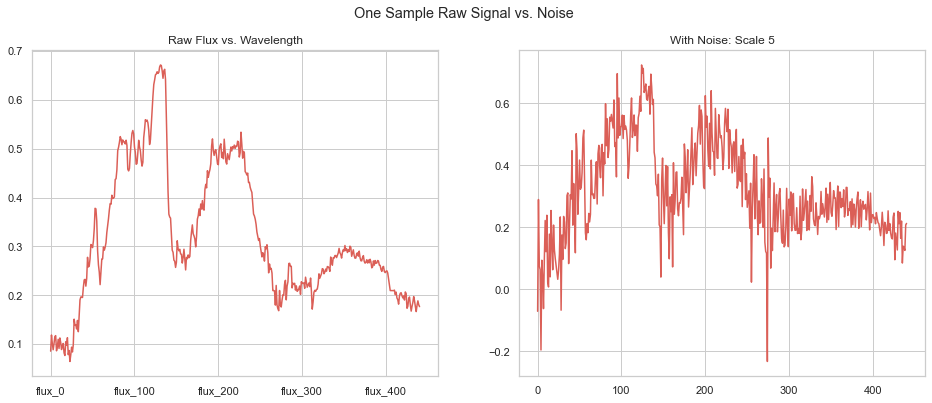

In [348]:
def plot_raw_and_noise(flux_df, noise_df, scale):
    sample = flux_df.sample(1)
    with_noise = add_noise(sample, noise_df.loc[sample.index], scale)

    fig, ax = plt.subplots(1, 2, figsize=(16 ,6))
    sample.T.plot(ax=ax[0], legend=None)
    ax[0].set_title("Raw Flux vs. Wavelength")
    pd.Series(with_noise[0]).plot(ax=ax[1])
    ax[1].set_title(f"With Noise: Scale {scale}")
    plt.suptitle("One Sample Raw Signal vs. Noise")


plot_raw_and_noise(binaries_flux, binaries_noise, 5)

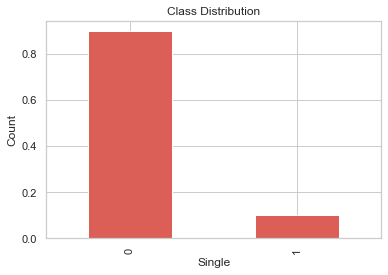

In [100]:
df["single"].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Single")
plt.ylabel("Count")
plt.title("Class Distribution");

In [266]:
pd.Series(((binaries_diff.values / (binaries_noise.values + 10e-50)) ** 2).sum(axis=1)).describe()

count     3.055300e+04
mean      9.228242e+95
std       8.777489e+97
min       1.370964e-40
25%       1.050354e+04
50%       2.295392e+04
75%       5.488902e+04
max      1.042707e+100
dtype: float64

In [273]:
wavegrids = pd.read_hdf("data/spectral_templates_data_version_june20.h5", key="wavegrid")
range_1 = wavegrids[(wavegrids >= 0.95) & (wavegrids <= 1.35)].dropna().index
range_2 = wavegrids[(wavegrids >= 1.45) & (wavegrids <= 1.80)].dropna().index
range_3 = wavegrids[(wavegrids >= 2.00) & (wavegrids <= 2.35)].dropna().index

Int64Index([311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
            ...
            413, 414, 415, 416, 417, 418, 419, 420, 421, 422],
           dtype='int64', length=112)

,chisq_095_135,chisq_145_180,chisq_200_235
0,3.912755e+05,2.793859e+05,4.915068e+04
1,1.823573e+05,2.362185e+05,9.085302e+04
2,2.361849e+05,2.305525e+05,4.528837e+05
3,1.770695e+05,3.031714e+05,1.446809e+05
4,1.201006e+05,1.237844e+05,4.582387e+04
...,...,...,...
30548,3.627013e+04,8.353367e+03,3.228532e+04
30549,7.287895e+102,8.969806e+102,3.943648e+102
30550,7.287895e+102,8.969806e+102,3.943648e+102
30551,2.715029e+74,3.231458e+74,2.717240e+74
